<a href="https://colab.research.google.com/github/ManavR123/generative_nst/blob/main/generative_nst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Generative Approach to Neural Style Transfer
_Authors:_ Harish Palani, Manav Rathod

This work was inspired by [Multi-Style Generative Network for Real-Time Transfer](https://arxiv.org/pdf/1703.06953.pdf), as well as [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
PROJ_DIR = 'drive/MyDrive/Fall 2020/VS 265/final-project/'

In [3]:
%cd drive/MyDrive/Fall 2020/VS 265/final-project/

/content/drive/MyDrive/Classwork/Year 3/Fall 2020/VS 265/final-project


In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from torch.autograd import Variable
from urllib.request import urlopen

In [5]:
class GramMatrix(nn.Module):
    def __init__(self):
        super(GramMatrix, self).__init__()

    def forward(self, x):
        features = x.view(x.size()[0], x.size()[1], (x.size()[2] * x.size()[3]))
        return features.bmm(features.transpose(1, 2)) / (x.size()[1] * x.size()[2] * x.size()[3])

In [6]:
class CoMatchLayer(nn.Module):
    def __init__(self):
        super(CoMatchLayer, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, 512, 512), requires_grad=True)
        self.target = Variable(torch.Tensor(1, 512, 512), requires_grad=True)

    def set_target(self, target):
        self.target = target

    def forward(self, x):
        return torch.bmm(torch.bmm(self.weight.expand_as(self.target), self.target).transpose(1, 2).expand(x.size(0), 512, 512), x.view(x.size(0), x.size(1), -1)).view_as(x)

In [7]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=None):
        super(ConvLayer, self).__init__()
        self.upsample = upsample
        self.reflection_pad = nn.ReflectionPad2d(int(np.floor(kernel_size / 2)))
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = nn.Upsample(scale_factor=self.upsample)(x)
        return self.conv2d(self.reflection_pad(x))

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, upsample=False, downsample=None):
        super(ResidualBlock, self).__init__()
        self.upsample = upsample
        self.downsample = downsample

        if self.upsample:
            self.residual_layer = ConvLayer(inplanes, (planes * 4), kernel_size=1, stride=1, upsample=stride)
        elif self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, (planes * 4), kernel_size=1, stride=stride)

        conv_block = []
        conv_block += [nn.InstanceNorm2d(inplanes), nn.ReLU(inplace=True), nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        
        if self.upsample:
            conv_block += [nn.InstanceNorm2d(planes), nn.ReLU(inplace=True), ConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        else:
            conv_block += [nn.InstanceNorm2d(planes), nn.ReLU(inplace=True), ConvLayer(planes, planes, kernel_size=3, stride=stride, upsample=False)]
        
        conv_block += [nn.InstanceNorm2d(planes), nn.ReLU(inplace=True), nn.Conv2d(planes, (planes * 4), kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        residual = x
        if (self.upsample) or (self.downsample is not None):
            residual = self.residual_layer(x)
        return residual + self.conv_block(x)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        siamese = []
        siamese += [ConvLayer(3, 64, kernel_size=7, stride=1, upsample=False), nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                    ResidualBlock(64, 32, stride=2, downsample=1), ResidualBlock(128, 128, stride=2, downsample=1)]

        self.siamese = nn.Sequential(*siamese)
        self.comatch = CoMatchLayer()
        self.gram = GramMatrix()

        model = []
        model += [self.siamese]
        model += [self.comatch]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 128, stride=1)]
        model += [ResidualBlock(512, 32, stride=2, upsample=True), ResidualBlock(128, 16, stride=2, upsample=True),
                  nn.InstanceNorm2d(64), nn.ReLU(inplace=True), ConvLayer(64, 3, kernel_size=7, stride=1, upsample=False)]

        self.model = nn.Sequential(*model)

    def set_target(self, x):
        self.comatch.set_target(self.gram(self.siamese(x)))

    def forward(self, input):
        return self.model(input)

In [10]:
im_content = Image.open(urlopen('https://www.berkeleyside.com/wp-content/uploads/2018/04/Wheeler.jpg')).convert('RGB')
im_style = Image.open(urlopen('https://upload.wikimedia.org/wikipedia/commons/f/f4/The_Scream.jpg')).convert('RGB')

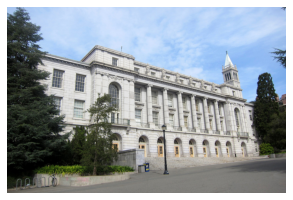

In [11]:
fig = plt.figure(figsize=(5, 5))
plt.axis('off')

plt.imshow(im_content)

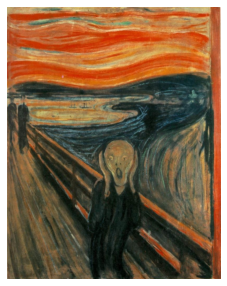

In [12]:
fig = plt.figure(figsize=(5, 5))
plt.axis('off')

plt.imshow(im_style)

In [13]:
im_content = torch.from_numpy(np.array(im_content.resize((640, int(640 * (im_content.size[1] / im_content.size[0]))), Image.ANTIALIAS)).transpose(2, 0, 1))
im_content = im_content.float().unsqueeze(0).cuda().transpose(0, 1)

r, g, b = torch.chunk(im_content, 3)
im_content = Variable(torch.cat((b, g, r)).transpose(0, 1))

In [14]:
im_style = torch.from_numpy(np.array(im_style.resize((512, 512), Image.ANTIALIAS)).transpose(2, 0, 1))
im_style = im_style.float().unsqueeze(0).cuda().transpose(0, 1)

r, g, b = torch.chunk(im_style, 3)
im_style = torch.cat((b, g, r)).transpose(0, 1)

In [15]:
model = Net()
model.load_state_dict(torch.load('weights.model'), False)

model.cuda()
model.set_target(Variable(im_style))
r, g, b = torch.chunk(model(im_content).data[0], 3)

In [16]:
im_out = Image.fromarray(torch.cat((b, g, r)).clone().cpu().clamp(0, 255).numpy().transpose(1, 2, 0).astype('uint8'))

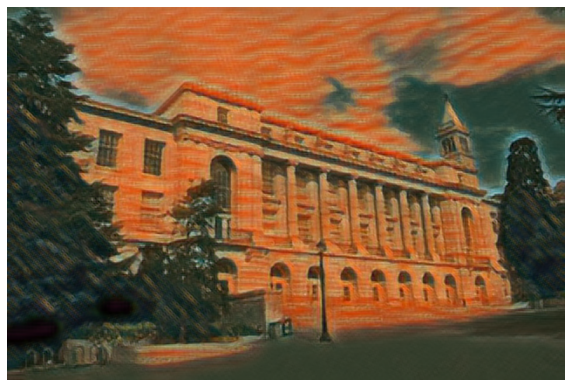

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.axis('off')

plt.imshow(im_out)